# Projet SY09 - Bigfoot

A FAIRE :
* essayer de placer le résultat de l'ACP en entrée des autres algos

## Import des bibiliothèques

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from utils import plot_clustering, add_decision_boundary, plot_dendrogram, scatterplot_pca

## Préparation du jeu de données

In [2]:
# importer données du fichier csv
bigfoot = pd.read_csv("../data/bigfoot.csv", sep = ",")

### Features engineering

* https://www.kdnuggets.com/2018/12/feature-engineering-explained.html
* https://www.kdnuggets.com/2018/12/feature-building-techniques-tricks-kaggle.html

Changements par rapport au rapport intermédiaire :
* On retire toutes les classes C
* Comme on a pas de visualisation, on prend directement le numéro du mois pour avoir une variable numérique
* On a plus besoin de la variable date (elle est maintenant redondante avec les variables year, month et day)
* On ajoute les variables r et theta (coordonnées polaires) à partir de la latitude et longitude (dans le cas où les classes seraient en cercles concentriques)
* On encode les variables precip_type et season sur plusieurs variables (one-hot-encoding : chaque nouvelle variable est une valeur possible, et la valeur de cette variable est à 1 si c'est la valeur de la variable originelle, à 0 sinon)
* On supprime les variables precip_type et season

In [3]:
bigfoot = bigfoot[bigfoot.classification != "Class C"]

In [4]:
# ajoute des colonnes jour, mois, année
year = bigfoot['date'].copy()
month = bigfoot['date'].copy()
day = bigfoot['date'].copy()

for i in bigfoot['date'].index:
    d = bigfoot['date'][i]
    if str(d) != "nan":
        d_datetime = datetime.strptime(str(d),'%Y-%m-%d')
        year[i] = d_datetime.year
        month[i] = d_datetime.month
        day[i] = d_datetime.day

bigfoot = bigfoot.assign(year = year)
bigfoot = bigfoot.assign(month = month)
bigfoot = bigfoot.assign(day = day)

# temperature_high : fahrenheit en celsius
# temperature_mid : fahrenheit en celsius
# temperature_low : fahrenheit en celsius
# dew_point : fahrenheit en celsius
# wind_speed : miles par heure en kilomètre par heure
# precip_intensity : inch en cm
# visibility : miles en kilomètre
# latitude / longitude : coordonnées polaires
bigfoot = bigfoot.assign(
    temperature_high = (bigfoot.temperature_high - 32) * 5 / 9,
    temperature_mid = (bigfoot.temperature_mid - 32) * 5 / 9,
    temperature_low = (bigfoot.temperature_low - 32) * 5 / 9,
    dew_point = (bigfoot.dew_point - 32) * 5 / 9,
    wind_speed = bigfoot.wind_speed * 1.609344,
    precip_intensity = bigfoot.precip_intensity * 2.54,
    visibility = bigfoot.visibility * 1.609344,
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)

# pour le "titre" garde la partie [titre] du format inital “Report [numéro] : [titre]”
bigfoot = bigfoot.assign(
    title = bigfoot.title.str.replace(r'^Report \d*: ', '')
)

# transformation de precip_type en deux colonnes snow et rain
# transformation de season en quatre colonnes
bigfoot["rain"] = 0.0
bigfoot.loc[bigfoot.precip_type == "rain", "rain"] = 1.0
bigfoot["snow"] = 0.0
bigfoot.loc[bigfoot.precip_type == "snow", "snow"] = 1.0
bigfoot["summer"] = 0.0
bigfoot.loc[bigfoot.season == "Summer", "summer"] = 1.0
bigfoot["spring"] = 0.0
bigfoot.loc[bigfoot.season == "Spring", "spring"] = 1.0
bigfoot["fall"] = 0.0
bigfoot.loc[bigfoot.season == "Fall", "fall"] = 1.0
bigfoot["winter"] = 0.0
bigfoot.loc[bigfoot.season == "Winter", "winter"] = 1.0

bigfoot.drop(columns="geohash", inplace=True)
bigfoot.drop(columns="date", inplace=True)
bigfoot.drop(columns=["precip_type"], inplace=True)

### Typage des variables

Changements par rapport au rapport intermédiaire :
* day, month, year castés à float pour éviter d'avoir les nan spécifiques aux entiers

In [5]:
# dictionnaire des états des Etats-Unis et leur abbrévation
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

# variables catégorielles
# Attention! Conséquence, variables catégorielles ont des valeurs <NA> à la place de NaN.
bigfoot.county = pd.Categorical(bigfoot.county)
bigfoot.state = pd.Categorical(bigfoot.state, categories=us_state_to_abbrev.keys())
bigfoot.classification = bigfoot.classification.replace("Class A", "A")
bigfoot.classification = bigfoot.classification.replace("Class B", "B")
bigfoot.classification = pd.Categorical(bigfoot.classification, categories=["A", "B"], ordered=True)

bigfoot.observed = bigfoot.observed.astype('str')
bigfoot.location_details = bigfoot.location_details.astype('str')
bigfoot.title = bigfoot.title.astype('str')
bigfoot.summary = bigfoot.summary.astype('str')
bigfoot.number = bigfoot.number.astype('Int64')
bigfoot.day = bigfoot.day.astype(float)
bigfoot.month = bigfoot.month.astype(float)
bigfoot.year = bigfoot.year.astype(float)

### Observer les corrélations pour supprimer des variables

<Axes: >

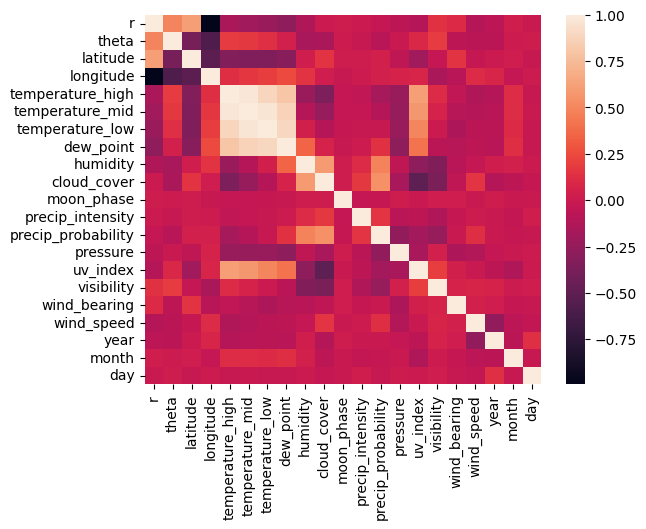

In [6]:
features = [
    'r',
    'theta',
    'latitude',
    'longitude',
    'temperature_high',
    'temperature_mid',
    'temperature_low',
    'dew_point',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]

corr = bigfoot[features].corr()
sns.heatmap(corr)

<Axes: >

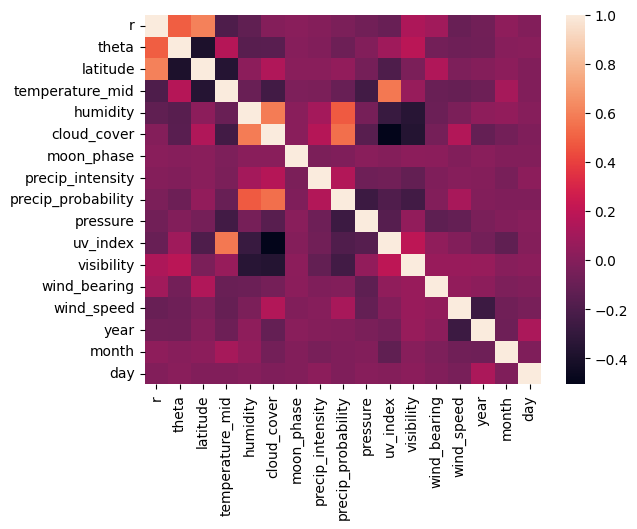

In [7]:
features = [
    'r',
    'theta',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]
corr = bigfoot.drop(columns=["temperature_high", "temperature_low", "dew_point", "longitude"])[features].corr()
sns.heatmap(corr)

In [8]:
bigfoot.drop(columns=["temperature_high", "temperature_low", "dew_point"], inplace=True)

features = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
    'r',
    'theta',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]

cat_cols = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow',
]

num_cols = [
    'r',
    'theta',
    'latitude',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
]

## Apprentissage non-supervisé

### FAMD (Factorial Analysis of Mixed Data)

* https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b
* https://datascience.stackexchange.com/questions/55119/how-to-handle-missing-date-data
* https://www.kaggle.com/code/dextermojo/eda-with-kmeans-and-famd
* https://developers.google.com/machine-learning/data-prep/transform/normalization?hl=en
* https://maxhalford.github.io/prince/famd/

<b>POURQUOI ON A BESOIN D'UNE FAMD ?</b>

Le but de le FAMD est de faire une ACP sur un jeu de données contenant à la fois des données numériques, et des données catégorielles.

Dans notre cas, les données numériques sont :
* r
* theta
* latitude
* temperature_mid
* humidity
* cloud_cover
* moon_phase
* precip_intensity
* precip_probability
* pressure
* uv_index
* visibility
* wind_bearing
* wind_speed
* year
* month
* day

Les données catégorielles considérées sont :
* summer
* winter
* fall
* spring
* rain
* snow

Le principe est de préparer les données numériques et catégorielles séparemment, pour les convertir en variables numériques sans valeur manquante, et ensuite faire une ACP dessus.

<br>

<b>COMMENT FAIRE UNE FAMD ?</b>

Pour les variables numériques, on doit d'abord remplir les valeurs manquantes. On remplace les valeurs manquantes par la moyenne de la variable. Pour latitude, r et theta, on peut affiner en prenant la moyenne pour le county associé (valeur toujours présente). Idem pour year, month, day avec la valeur pour season (valeur toujours présente) et en remplaçant par la médiane (valeurs discrètes). Puis on doit les standardiser pour qu'elles aient toutes la même importance dans l'ACP (fonction calculate_zscore). 

Dans la première partie, on a recodé les variables catégorielles en one-hot-encoding, on n'a pas de valeurs manquantes en conséquence (juste les deux colonnes de valeurs à 0). Pour standardiser, on remplace chaque valeur par la racine de la probablité de tomber dessus (variance à 1). Ce n'est pas la peine de centrer, la fonction PCA le fait.

On peut lancer l'ACP.

<br/>

<b>POURQUOI FAIRE UNE ACP/FAMD ?</b>

L'idée est de chercher à représenter nos données dans une dimension réduite, voir si des variables sont corrélées, et si une projection 2D permet d'observer une frontière entre les classes.

#### Transformations pré-ACP

In [9]:
def fill_missing(df):
    '''
    replace empty values by column's mean in dataframe
    '''
    return df.copy().fillna(df.mean())

In [10]:
def calculate_zscore(df):
    '''
    scales columns in dataframe using z-score
    '''
    df = df.copy()
    for col in df.columns:
        df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

    return df

In [11]:
def normalize_column_modality(df):
    '''
    divides each column by the probability μₘ of the modality 
    (number of ones in the column divided by N) only for one hot columns
    '''
    df = df.copy()
    length = len(df)
    for col in df.columns:
        weight = math.sqrt(sum(df[col])/length)
        df[col] = df[col]/weight

    return df

In [12]:
# Dealing with missing values
bigfoot[["latitude", "longitude"]] = bigfoot[["latitude", "longitude"]].fillna(bigfoot.groupby('state')[["latitude", "longitude"]].transform('mean'))
bigfoot = bigfoot.assign(
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)
bigfoot[["day", "month", "year"]] = bigfoot[["day", "month", "year"]].fillna(bigfoot.groupby('season')[["day", "month", "year"]].transform('median'))
bigfoot.head()

,observed,location_details,county,state,season,title,latitude,longitude,number,classification,...,month,day,r,theta,rain,snow,summer,spring,fall,winter
0,I was canoeing on the Sipsey river in Alabama....,nan,Winston County,Alabama,Summer,nan,33.071369,-86.653602,30680,B,...,7.0,15.0,92.749998,2.777004,0.0,0.0,1.0,0.0,0.0,0.0
1,Ed L. was salmon fishing with a companion in P...,East side of Prince William Sound,Valdez-Chitina-Whittier County,Alaska,Fall,nan,60.167644,-142.750109,1261,A,...,10.0,15.0,154.912036,2.742699,0.0,0.0,0.0,0.0,1.0,0.0
2,"While attending U.R.I in the Fall of 1974,I wo...","Great swamp area, Narragansett Indians",Washington County,Rhode Island,Fall,Report 6496: Bicycling student has night encou...,41.450000,-71.500000,6496,A,...,9.0,20.0,82.645947,2.616218,0.0,0.0,0.0,0.0,1.0,0.0
3,"Hello, My name is Doug and though I am very re...",I would rather not have exact location (listin...,York County,Pennsylvania,Summer,nan,40.897262,-78.282861,8000,B,...,7.0,15.0,88.322095,2.660163,0.0,0.0,1.0,0.0,0.0,0.0
4,It was May 1984. Two friends and I were up in ...,"Logging roads north west of Yamhill, OR, about...",Yamhill County,Oregon,Spring,nan,44.423294,-122.125632,703,B,...,5.0,15.0,129.954219,2.792721,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
bigfoot_famd_num = pd.DataFrame(calculate_zscore(fill_missing(bigfoot[num_cols])))
bigfoot_famd_cat = normalize_column_modality(bigfoot[cat_cols])
bigfoot_famd = pd.concat([bigfoot_famd_num, bigfoot_famd_cat], axis=1)
bigfoot_famd

,r,theta,latitude,temperature_mid,humidity,cloud_cover,moon_phase,precip_intensity,precip_probability,pressure,...,wind_speed,year,month,day,summer,winter,fall,spring,rain,snow
0,-0.747332,0.439927,-1.181498,2.443379e-16,-8.412105e-16,0.000000,-4.675644e-16,1.848644e-17,0.000000,-2.555174e-14,...,0.000000,0.248445,-0.067941,0.069109,1.639411,0.0,0.00000,0.000000,0.0,0.0
1,2.942550,-0.123299,3.724751,2.443379e-16,-8.412105e-16,0.000000,-4.675644e-16,1.848644e-17,0.000000,-2.555174e-14,...,0.000000,0.248445,0.952401,0.069109,0.000000,0.0,1.83267,0.000000,0.0,0.0
2,-1.347099,-2.199884,0.335598,1.192347e+00,1.170190e+00,1.610229,-1.424402e+00,-1.547490e-01,-0.962195,7.937814e-01,...,1.136091,-1.930530,0.612287,0.716726,0.000000,0.0,1.83267,0.000000,0.0,0.0
3,-1.010168,-1.478392,0.235515,2.443379e-16,-8.412105e-16,0.000000,-4.675644e-16,1.848644e-17,0.000000,-2.555174e-14,...,0.000000,0.248445,-0.067941,0.069109,1.639411,0.0,0.00000,0.000000,0.0,0.0
4,1.461077,0.697957,0.873964,2.443379e-16,-8.412105e-16,0.000000,-4.675644e-16,1.848644e-17,0.000000,-2.555174e-14,...,0.000000,0.323582,-0.748169,0.069109,0.000000,0.0,0.00000,2.467101,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,0.453107,1.140129,-0.697278,2.443379e-16,-8.412105e-16,0.000000,-4.675644e-16,1.848644e-17,0.000000,-2.555174e-14,...,0.000000,0.248445,-0.067941,0.069109,1.639411,0.0,0.00000,0.000000,0.0,0.0
5017,-1.131468,-1.316551,-0.072657,2.443379e-16,-8.412105e-16,0.000000,-4.675644e-16,1.848644e-17,0.000000,-2.555174e-14,...,0.000000,0.323582,-0.748169,0.069109,0.000000,0.0,0.00000,2.467101,0.0,0.0
5018,-1.085451,0.919268,-1.981543,2.443379e-16,-8.412105e-16,0.000000,-4.675644e-16,1.848644e-17,0.000000,-2.555174e-14,...,0.000000,0.248445,-0.067941,0.069109,1.639411,0.0,0.00000,0.000000,0.0,0.0
5019,-0.452832,-0.466601,0.041410,2.443379e-16,-8.412105e-16,0.000000,-4.675644e-16,1.848644e-17,0.000000,-2.555174e-14,...,0.000000,0.248445,0.952401,0.069109,0.000000,0.0,1.83267,0.000000,0.0,0.0


#### ACP

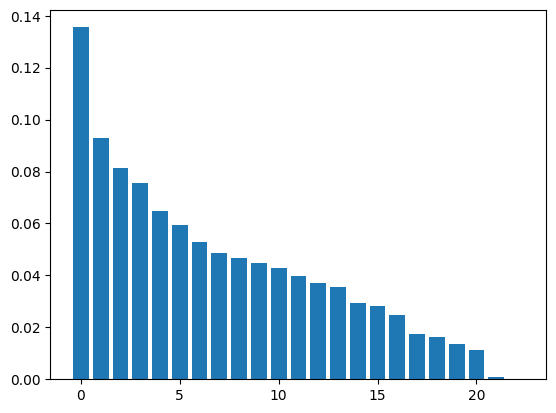

In [14]:
cls = PCA()
pcs = cls.fit_transform(bigfoot_famd)
plt.bar(range(cls.components_.shape[0]), cls.explained_variance_ratio_)
plt.show()

In [16]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(cls.explained_variance_.size)], 
        "Variance expliquée" : cls.explained_variance_,
        "% variance expliquée" : np.round(cls.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(cls.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,2.938560,14.0,14.0
1,Dim2,2.012809,9.0,23.0
2,Dim3,1.761455,8.0,31.0
3,Dim4,1.634830,8.0,39.0
4,Dim5,1.402809,6.0,45.0
5,Dim6,1.290103,6.0,51.0
6,Dim7,1.149411,5.0,56.0
7,Dim8,1.055942,5.0,61.0
8,Dim9,1.011730,5.0,66.0
9,Dim10,0.966567,4.0,70.0


Avec la technique du coude, il semblerait qu'on ait besoin de 8 composantes pour représenter nos données. Cela donnerait 61% de variance expliquée au total. C'est pas folichon...

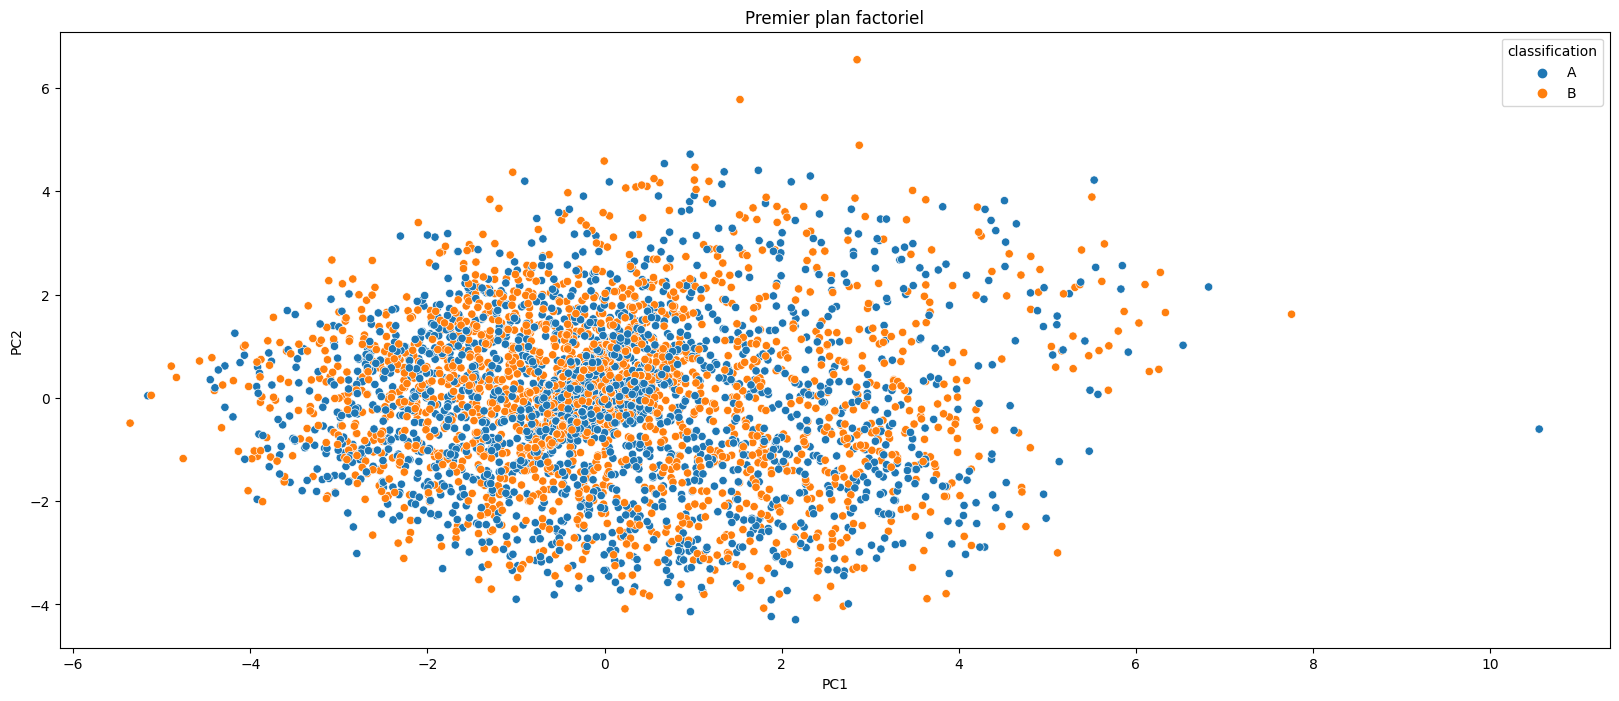

In [17]:
plt.figure(figsize=(20,8))
df_X = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(cls.components_.shape[0])])
sns.scatterplot(x="PC1", y="PC2", hue=bigfoot.classification, data=df_X)
plt.title("Premier plan factoriel")
plt.show()

In [18]:
n = bigfoot_famd.shape[0] # nb individus
p = bigfoot_famd.shape[1] # nb variables
eigval = (n-1) / n * cls.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = cls.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': features, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})
coordvar

,id,COR_1,COR_2
0,summer,-0.031349,0.419527
1,winter,-0.289131,0.060577
2,fall,0.260346,0.398562
3,spring,-0.568403,-0.636344
4,rain,0.646738,-0.333543
5,snow,0.758288,-0.246875
6,r,0.000237,0.052314
7,theta,0.185421,-0.083230
8,latitude,0.606656,-0.473598
9,temperature_mid,-0.036540,0.436523


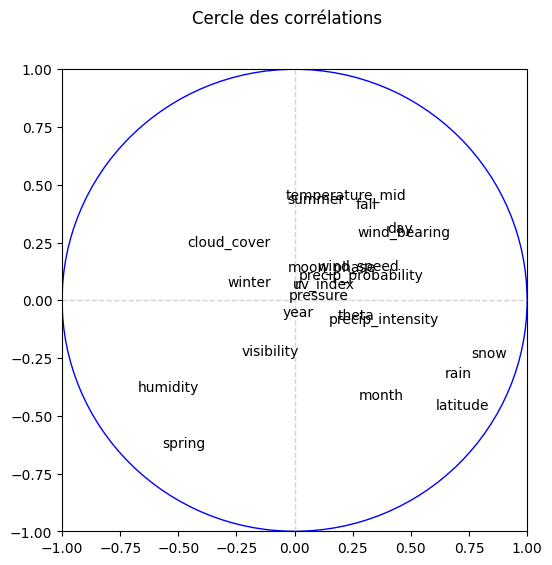

In [19]:
# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

Conclusion : la FAMD donne pas grand chose. On peut juste apprendre que un certains nombre de variables sont corrélées entre elles avec la cercle de corrélation (par exemple : summer-temperature_mid, precip_probability-moon_phase...). On décide de garder l'ensemble de nos variables plutôt que de prendre certaines des composantes.

### CAH

<b>POURQUOI UNE CAH ?<b>
    
On va s'en servir pour déterminer le nombre de classes à représenter. Dans notre cas, pas très utile puisqu'on sait le nombre de classes qu'on recherche.

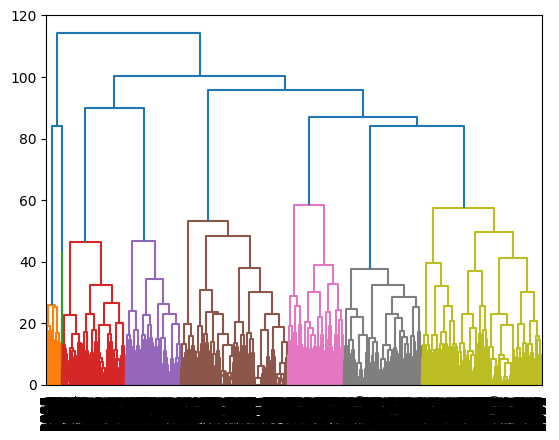

In [20]:
cls = AgglomerativeClustering(linkage="ward", metric="euclidean", distance_threshold=0, n_clusters=None)
cls.fit(bigfoot_famd)
plot_dendrogram(cls)

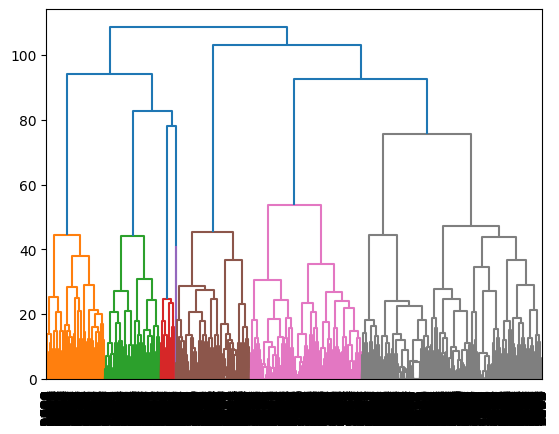

In [32]:
cls = AgglomerativeClustering(linkage="ward", metric="euclidean", distance_threshold=0, n_clusters=None)
cls.fit(pcs[:,:12])
plot_dendrogram(cls)

### K-means

* https://medium.com/analytics-vidhya/implementation-of-principal-component-analysis-pca-in-k-means-clustering-b4bc0aa79cb6

<b>POURQUOI UN K-MEANS ?<b>
    
Pour essayer de retrouver nos classes pardi !
    
<br>
    
<b>ATTENTION ON UTILISE BIEN NOS DONNÉES DE DÉPART ET PAS CE QUI VIENT DE LA FAMD<b>

In [22]:
kmeans3 = KMeans(n_clusters=2, n_init=10)
kmeans3.fit(bigfoot_famd)
pd.Series(kmeans3.labels_).value_counts()

1    3840
0    1151
Name: count, dtype: int64

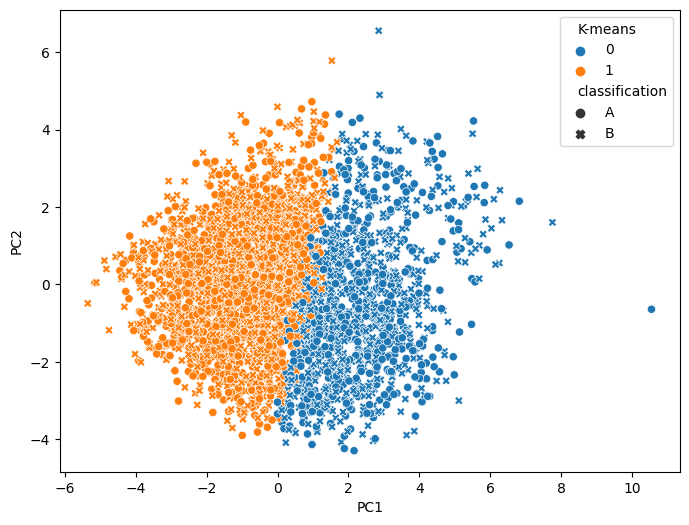

In [23]:
plt.figure(figsize=(8,6))
labels = pd.Series(kmeans3.labels_, name="K-means")
ax, _ = scatterplot_pca(data=bigfoot_famd, hue=labels, style=bigfoot.classification)
plt.show()
fig = ax.get_figure()

In [24]:
bigfoot_k3 = bigfoot_famd.assign(classe_kmean = kmeans3.labels_)
bigfoot_k3.groupby("classe_kmean").mean()

,r,theta,latitude,temperature_mid,humidity,cloud_cover,moon_phase,precip_intensity,precip_probability,pressure,...,wind_speed,year,month,day,summer,winter,fall,spring,rain,snow
classe_kmean,,,,,,,,,,,,,,,,,,,,,
0,-0.036198,-0.227616,0.203990,-0.593243,0.908636,1.103216,-0.015964,0.218315,1.161699,-0.254556,...,0.197406,0.200268,-0.061145,0.019707,0.381722,0.631346,0.620974,0.413684,1.386409,0.720762
1,0.010850,0.068225,-0.061144,0.177818,-0.272354,-0.330678,0.004785,-0.065438,-0.348207,0.076301,...,-0.059170,-0.060028,0.018327,-0.005907,0.678392,0.311569,0.523075,0.402831,0.310155,0.017399


Le résultat est clairement pas ouf, on va pas se mentir. Essayons avec la nombre de classes venant de la CAH. Avant, on vérifie qu'on trouve le même nombre de classes en essayant des valeurs successives.

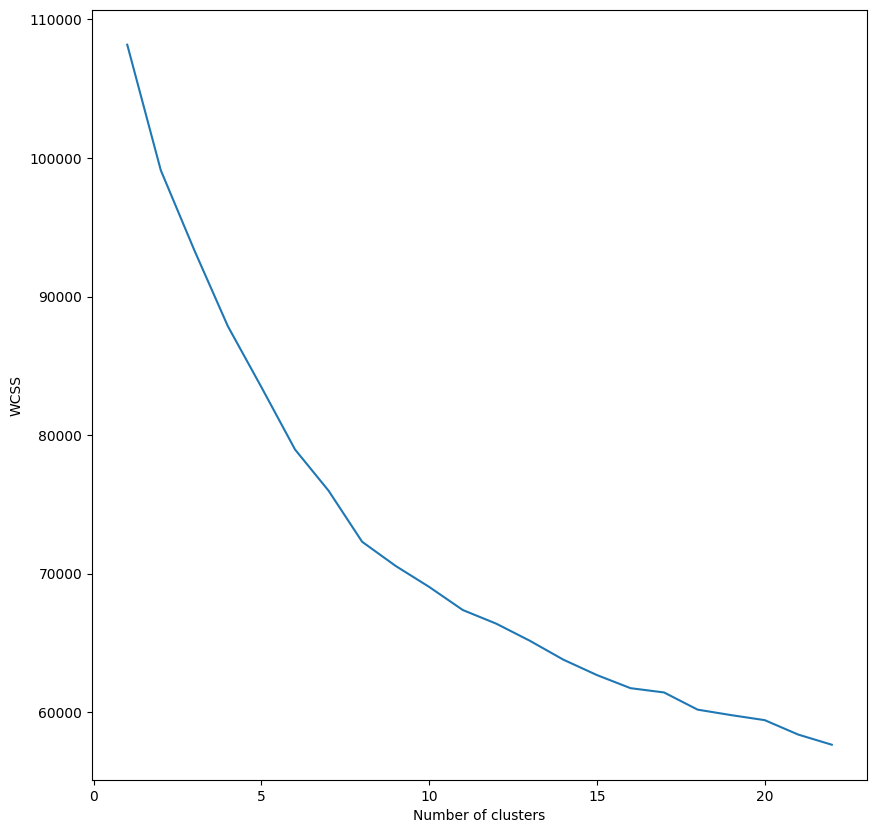

In [25]:
wcss = [] # sum of squares of distances of datapoints
for i in range(1,23):
    kmeans3 = KMeans(n_clusters=i, n_init=10)
    kmeans3.fit(bigfoot_famd)
    wcss.append(kmeans3.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,23), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [26]:
kmeans3 = KMeans(n_clusters=8, n_init=10)
kmeans3.fit(bigfoot_famd)
pd.Series(kmeans3.labels_).value_counts()

1    1147
0     989
3     767
2     701
6     655
7     570
4     159
5       3
Name: count, dtype: int64

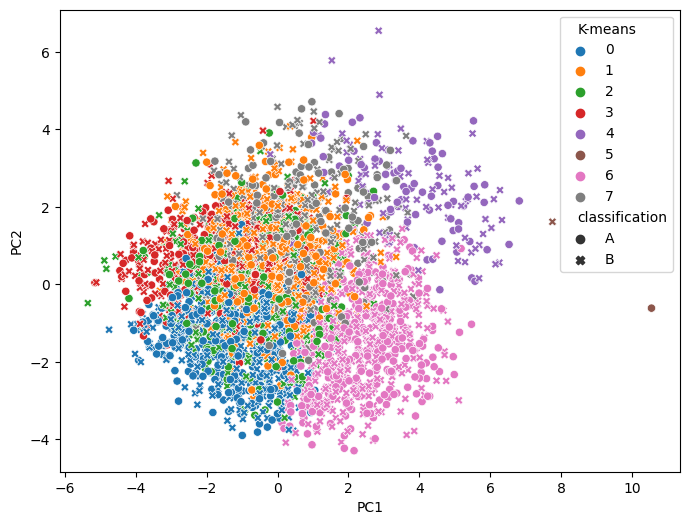

In [27]:
plt.figure(figsize=(8,6))
labels = pd.Series(kmeans3.labels_, name="K-means")
ax, _ = scatterplot_pca(data=bigfoot_famd, hue=labels, style=bigfoot.classification)
plt.show()
fig = ax.get_figure()

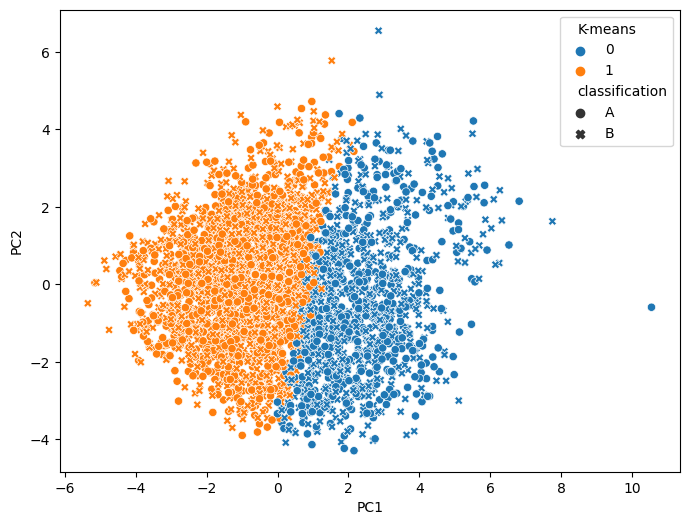

In [33]:
kmeans3 = KMeans(n_clusters=2, n_init=10)
kmeans3.fit(pcs[:,:12])
plt.figure(figsize=(8,6))
labels = pd.Series(kmeans3.labels_, name="K-means")
ax, _ = scatterplot_pca(data=bigfoot_famd, hue=labels, style=bigfoot.classification)
plt.show()
fig = ax.get_figure()

## Apprentissage supervisé

In [ ]:
# Séparer le jeu de donnéees
X_train, X_test, y_train, y_test = train_test_split(bigfoot_famd, bigfoot.classification, train_size=0.66)

### K plus proches voisins

Vu la tête de la FAMD, faut pas s'attendre à grand chose.

In [ ]:
# validation croisées pour trouver le meilleur nombre de voisins

# De 1 à 500 voisins (exclu), échelle logarithmique
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))
param_grid = {"n_neighbors": n_neighbors_list}

cls = KNeighborsClassifier()
search = GridSearchCV(cls, param_grid, scoring="accuracy", cv=10)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)
print(accuracy_score(y_pred, y_test), search.best_params_)